<a href="https://colab.research.google.com/github/likevin9911/Machine-Learning-Projects/blob/main/Numpy_Single_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.datasets import mnist
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Simple Neural Networks/mnist_test.csv')
data.head()

In [ ]:
# Extract features and labels
x = data.iloc[:, 1:].values #features
y = data.iloc[:, 0 ].values #label

# randomization
shuffled_indices = np.random.permutation(len(data))
x = x[shuffled_indices]
y = y[shuffled_indices]

# split into 80/20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# normalize 0:255 grayscale
x_train = x_train / 255
x_test = x_test / 255


Epoch 1/50, Train Accuracy: 0.0904, Test Accuracy: 0.1015, Train Loss: 4.2063, Test Loss: 4.3006
Epoch 2/50, Train Accuracy: 0.0943, Test Accuracy: 0.1060, Train Loss: 3.5720, Test Loss: 3.6333
Epoch 3/50, Train Accuracy: 0.1045, Test Accuracy: 0.1160, Train Loss: 3.2369, Test Loss: 3.2781
Epoch 4/50, Train Accuracy: 0.1160, Test Accuracy: 0.1190, Train Loss: 3.0310, Test Loss: 3.0591
Epoch 5/50, Train Accuracy: 0.1343, Test Accuracy: 0.1310, Train Loss: 2.8936, Test Loss: 2.9126
Epoch 6/50, Train Accuracy: 0.1485, Test Accuracy: 0.1510, Train Loss: 2.7920, Test Loss: 2.8043
Epoch 7/50, Train Accuracy: 0.1586, Test Accuracy: 0.1670, Train Loss: 2.7092, Test Loss: 2.7162
Epoch 8/50, Train Accuracy: 0.1708, Test Accuracy: 0.1835, Train Loss: 2.6369, Test Loss: 2.6402
Epoch 9/50, Train Accuracy: 0.1856, Test Accuracy: 0.1945, Train Loss: 2.5705, Test Loss: 2.5712
Epoch 10/50, Train Accuracy: 0.2016, Test Accuracy: 0.2090, Train Loss: 2.5082, Test Loss: 2.5066
Epoch 11/50, Train Accuracy: 

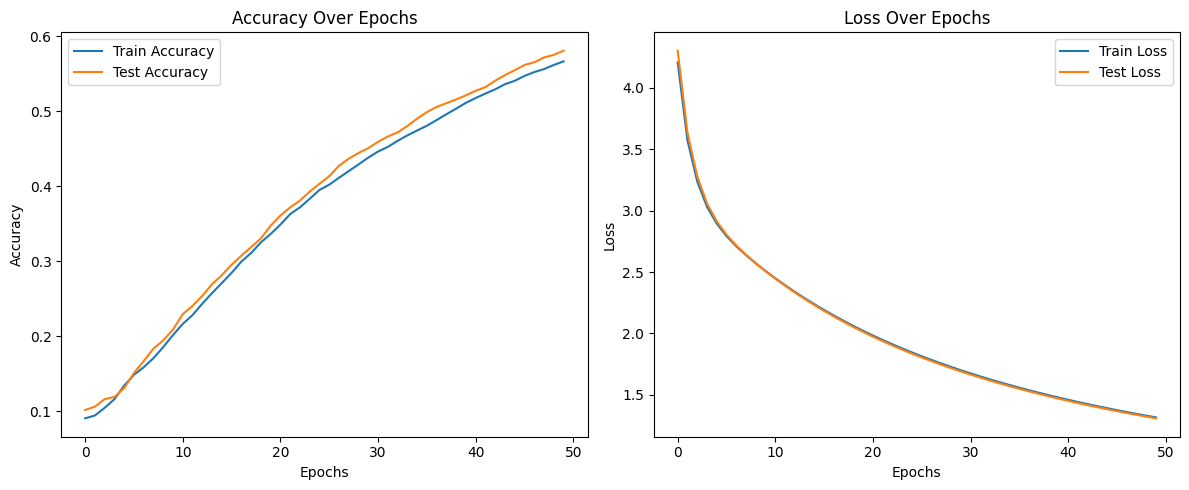

In [ ]:
# determine the dimensions
input_dim = x_train.shape[1]
hidden_dim1 = 64
output_dim = len(np.unique(y_train))
init_range = 1

# Deep Learning initialization techniques
  # def xavier_init(size):
  #   in_dim, out_dim = size
  #   xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
  #   return np.random.randn(out_dim, in_dim) * xavier_stddev

  # def he_init(size):
  #   in_dim, out_dim = size
  #   he_stddev = np.sqrt(2 / in_dim)
  #   return np.random.randn(out_dim, in_dim) * he_stddev

w1 = np.random.uniform(-init_range, init_range, (hidden_dim1, input_dim))
b1 = np.zeros((hidden_dim1, 1))
w2 = np.random.uniform(-init_range, init_range, (output_dim, hidden_dim1))
b2 = np.zeros((output_dim, 1))

def batch_norm_forward(x, gamma, beta, eps=1e-5):
  mu = np.mean(x, axis=0)
  var = np.var(x, axis=0)
  x_norm = (x - mu) / np.sqrt(var + eps)
  out = gamma * x_norm + beta
  return mu, var, x_norm, out

def sigmoid(x): # Sigmoid Activation Function
  return 1 / (1 + np.exp(-x))

def ReLu(z): # ReLu Activation Function
  return np.maximum(z, 0)

def softmax(z): # Softmax
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def forward_prop(x, w1, b1, w2, b2):
  z1 = w1.dot(x)+b1
  a1 = sigmoid(z1) # Activation Function
  z2 = w2.dot(a1)+b2
  a2 = softmax(z2) # Activation Function
  return z1, a1, z2, a2

def deriv_sigmoid(x):
  sig = sigmoid(x)
  return sig * (1 - sig)

def deriv_ReLu(z):
  return z > 0

def one_hot(y, num_classes):
  one_hot_y = np.zeros((y.size, num_classes))
  one_hot_y[np.arange(y.size), y] = 1
  one_hot_y = one_hot_y.T
  return one_hot_y

def back_prop(x, y, z1, a1, z2, a2, w1, w2, l2_lambda):
  m = y.size
  one_hot_y = one_hot(y, a2.shape[0])
  dz2 = a2 - one_hot_y
  dw2 = 1 / m * dz2.dot(a1.T) + (l2_lambda / m) * w2
  db2 = 1 / m * np.sum(dz2, axis=1, keepdims=True)

  da1 = w2.T.dot(dz2)
  dz1 = da1 * deriv_sigmoid(z1)
  dw1 = 1 / m * dz1.dot(x.T) + (l2_lambda / m) * w1
  db1 = 1 / m * np.sum(dz1, axis=1, keepdims=True)
  return dw1, db1, dw2, db2

def update_params(params, grads, learning_rate):
  for key in params.keys():
    params[key] -= learning_rate * grads[key]

def compute_loss(a2, y, w1, w2, l2_lambda):
  m = y.size
  one_hot_y = one_hot(y, a2.shape[0])
  log_probs = -np.log(a2[one_hot_y == 1])
  data_loss = np.sum(log_probs) / m
  l2_loss = l2_lambda / (2 * m) * (np.sum(np.square(w1)) + np.sum(np.square(w2)))
  return data_loss + l2_loss

def train_model(x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate, l2_lambda):
  num_classes = len(np.unique(y_train))
  params = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}
  train_accuracies = []
  test_accuracies = []
  train_losses = []
  test_losses = []

  for epoch in range(epochs):
    permutation = np.random.permutation(x_train.shape[0])
    x_train_shuffled = x_train[permutation]
    y_train_shuffled = y_train[permutation]

    for i in range(0, x_train.shape[0], batch_size):
      x_batch = x_train_shuffled[i:i+batch_size].T
      y_batch = y_train_shuffled[i:i+batch_size]

      z1, a1, z2, a2 = forward_prop(x_batch, params['w1'], params['b1'], params['w2'],  params['b2'])
      dw1, db1, dw2, db2 = back_prop(x_batch, y_batch, z1, a1, z2, a2,  params['w1'], params['w2'],  l2_lambda)
      grads = {'w1': dw1, 'b1': db1, 'w2': dw2, 'b2': db2}
      update_params(params, grads, learning_rate)

    # Training metrics
    z1, a1, z2, a2 = forward_prop(x_train.T, params['w1'], params['b1'], params['w2'], params['b2'])
    train_predictions = np.argmax(a2, axis=0)
    train_accuracy = np.mean(train_predictions == y_train)
    train_loss = compute_loss(a2, y_train, params['w1'], params['w2'], l2_lambda)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation metrics
    z1, a1, z2, a2 = forward_prop(x_test.T, params['w1'], params['b1'], params['w2'], params['b2'])
    test_predictions = np.argmax(a2, axis=0)
    test_accuracy = np.mean(test_predictions == y_test)
    test_loss = compute_loss(a2, y_test, params['w1'], params['w2'], l2_lambda)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

  return train_accuracies, test_accuracies, train_losses, test_losses

epochs = 50
batch_size = 32
learning_rate = 0.001
l2_lambda = 0.01

train_accuracies, test_accuracies, train_losses, test_losses = train_model(x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate, l2_lambda)

# Plot the metrics
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()